In [94]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
import os
import matplotlib.pyplot as plt

In [95]:
tf.random.set_seed(23)

In [96]:
# Cargar y Preprocesar el Dataset
dataset_dir = "../datasets"
image_size = (460, 440)  # MobileNetV3 espera imágenes de 440x440
batch_size = 16

train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(dataset_dir, "train"),
    labels="inferred",
    label_mode="int",
    image_size=image_size,
    interpolation="bicubic",
    batch_size=batch_size,
    shuffle=True,
    follow_links=False,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(dataset_dir, "val"),
    labels="inferred",
    label_mode="int",
    image_size=image_size,
    interpolation="bicubic",
    batch_size=batch_size,
    shuffle=False,
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(dataset_dir, "test"),
    labels="inferred",
    label_mode="int",
    image_size=image_size,
    interpolation="bicubic",
    batch_size=batch_size,
    shuffle=False,
)

# Obtener los nombres de las clases (ordenados por el directorio)
class_names = train_ds.class_names
num_classes = len(class_names)
print(f"Clases detectadas: {class_names}")
print(f"Número de clases: {num_classes}")


Found 692 files belonging to 8 classes.
Found 82 files belonging to 8 classes.
Found 95 files belonging to 8 classes.
Clases detectadas: ['apamate', 'araguaney', 'arbolada-mango', 'caoba', 'ceiba', 'orquidea', 'roble', 'saman']
Número de clases: 8


In [97]:
def pad_and_top_crop(image, label, final_size=440):
    # Get current shape
    shape = tf.shape(image)
    height, width = shape[0], shape[1]
    # Make sure the image is at least final_size x final_size
    max_side = tf.maximum(tf.maximum(height, width), final_size)
    pad_height = max_side - height
    pad_width = max_side - width
    image = tf.image.pad_to_bounding_box(
        image,
        offset_height=pad_height // 2,
        offset_width=pad_width // 2,
        target_height=max_side,
        target_width=max_side
    )
    # Now crop to final_size x final_size from the top-left corner
    image = tf.image.crop_to_bounding_box(
        image,
        offset_height=0,
        offset_width=0,
        target_height=final_size,
        target_width=final_size
    )
    return image, label

# Usa tf.image.resize_with_pad para asegurar tamaño y padding correcto usando image_size
def resize_with_pad(image, label, final_size=image_size):
    image = tf.image.resize_with_pad(image, final_size[0], final_size[1])
    return image, label

# Aplica la función a tus datasets
train_ds = train_ds.map(lambda x, y: resize_with_pad(x, y, image_size), num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(lambda x, y: resize_with_pad(x, y, image_size), num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(lambda x, y: resize_with_pad(x, y, image_size), num_parallel_calls=tf.data.AUTOTUNE)

In [98]:
# Luego puedes seguir con tu data_augmentation y resize normal
data_augmentation = keras.Sequential([
    layers.Resizing(image_size[0], image_size[1]),  # Redimensiona a 460x440 después del padding
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
], name="data_augmentation")

In [99]:
# Aplicar aumento solo al conjunto de entrenamiento
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)

In [100]:
# Optimizar el rendimiento de la carga de datos
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

2025-07-06 00:05:11.561759: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


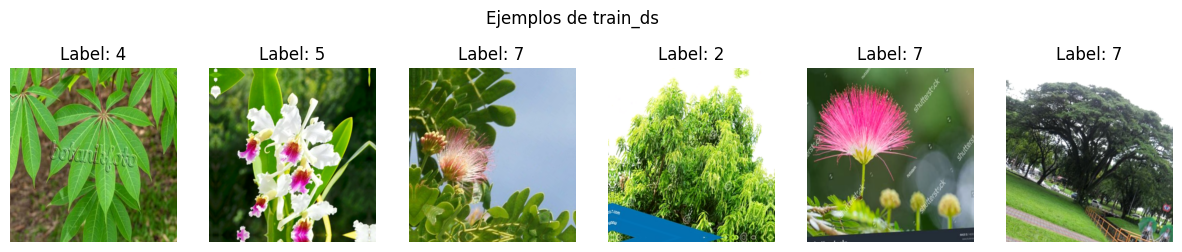

2025-07-06 00:05:12.304118: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


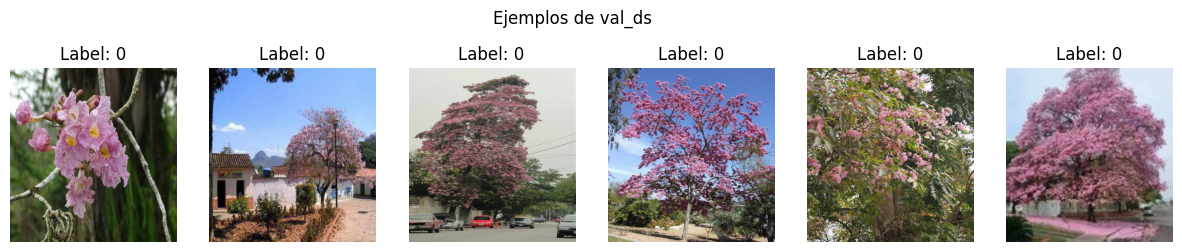

2025-07-06 00:05:12.473806: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-07-06 00:05:12.493036: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


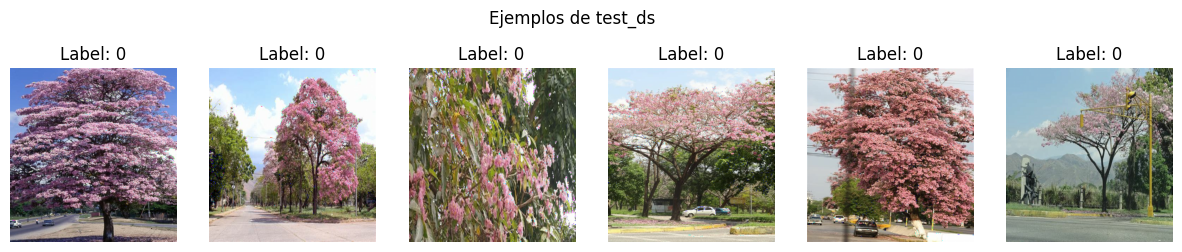

In [101]:
# Visualizar algunas imágenes de train, val y test después del preprocesamiento
import matplotlib.pyplot as plt

def show_batch(dataset, title, n=6):
    plt.figure(figsize=(15, 3))
    for images, labels in dataset.take(1):
        for i in range(n):
            ax = plt.subplot(1, n, i + 1)
            img = images[i].numpy().astype("uint8")
            plt.imshow(img)
            plt.title(f"Label: {labels[i].numpy()}")
            plt.axis("off")
    plt.suptitle(title)
    plt.show()

show_batch(train_ds, "Ejemplos de train_ds")
show_batch(val_ds, "Ejemplos de val_ds")
show_batch(test_ds, "Ejemplos de test_ds")

In [102]:
# Cargar MobileNetV3
base_model = tf.keras.applications.MobileNetV3Large(
    input_shape=image_size + (3,),
    include_top=False,
    weights='imagenet',
)

base_model.trainable = False  # No actualizar capas inferiores en las primeras épocas

/Users/karimsahili/Desktop/llovizna-ai/.venv/lib/python3.11/site-packages/keras/src/applications/mobilenet_v3.py:517: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


In [103]:
inputs = keras.Input(shape=image_size + (3,))
x = inputs

# Construir modelo de fine-tuning
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)  # Capa de dropout para regularización
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = keras.Model(inputs, outputs)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

model.summary()


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_20 (InputLayer)     │ (None, 460, 440, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Large (Functional)   │ (None, 15, 14, 960)    │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 960)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 8)              │         7,688 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,004,040 (11.46 MB)

 Trainable params: 7,688 (30.03 KB)

 Non-trainable params: 2,996,352 (11.43 MB)

In [104]:
# Definir el Early Stopping
early_stopping_callback = EarlyStopping(
    monitor="val_loss",
    patience=4,
    restore_best_weights=True,
    verbose=1,
)

In [105]:
epochs_initial = 10
print(f"\nEntrenando las capas superiores por {epochs_initial} épocas...")
history_initial = model.fit(
    train_ds,
    epochs=epochs_initial,
    validation_data=val_ds,
    callbacks=[early_stopping_callback],
)


Entrenando las capas superiores por 10 épocas...
Epoch 1/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 16s 302ms/step - accuracy: 0.2024 - loss: 2.3011 - val_accuracy: 0.5122 - val_loss: 1.3718
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 12s 278ms/step - accuracy: 0.4954 - loss: 1.3524 - val_accuracy: 0.6585 - val_loss: 1.0460
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 11s 255ms/step - accuracy: 0.6326 - loss: 1.0916 - val_accuracy: 0.7073 - val_loss: 0.9036
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 11s 258ms/step - accuracy: 0.6878 - loss: 0.9255 - val_accuracy: 0.6829 - val_loss: 0.8221
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 11s 259ms/step - accuracy: 0.7399 - loss: 0.7975 - val_accuracy: 0.6951 - val_loss: 0.7742
Epoch 6/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 11s 253ms/step - accuracy: 0.7730 - loss: 0.7339 - val_accuracy: 0.7073 - val_loss: 0.7277
Epoch 7/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 11s 256ms/step - accuracy: 0.7871 - loss: 0.6789 - val_accuracy: 0.7073 - val_loss: 0.7096
Epoch 8/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 11s 251ms

In [106]:
base_model.trainable = True

# Congelar capas de Batch Normalization (BN)
# Es una práctica común dejar las capas de Batch Normalization congeladas durante el fine-tuning,
# ya que sus estadísticas pueden volverse inestables con tamaños de batch pequeños.
for layer in base_model.layers:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False

# Recompilar el modelo con un learning rate más bajo
model.compile(
    optimizer=keras.optimizers.Adam(
        learning_rate=1e-5
    ),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

model.summary()


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_20 (InputLayer)     │ (None, 460, 440, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Large (Functional)   │ (None, 15, 14, 960)    │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 960)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 8)              │         7,688 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,004,040 (11.46 MB)

 Trainable params: 2,955,240 (11.27 MB)

 Non-trainable params: 48,800 (190.62 KB)

In [107]:
epochs_fine_tune = 10  # Más épocas para el fine-tuning profundo
total_epochs = epochs_initial + epochs_fine_tune

print(
    f"\nContinuando el entrenamiento (fine-tuning profundo) por {epochs_fine_tune} épocas..."
)
history_fine_tune = model.fit(
    train_ds,
    epochs=total_epochs,
    initial_epoch=history_initial.epoch[-1] + 1,
    validation_data=val_ds,
    callbacks=[early_stopping_callback],
)


Continuando el entrenamiento (fine-tuning profundo) por 10 épocas...
Epoch 11/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 44s 908ms/step - accuracy: 0.8682 - loss: 0.4548 - val_accuracy: 0.7317 - val_loss: 0.6008
Epoch 12/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 35s 801ms/step - accuracy: 0.8954 - loss: 0.3434 - val_accuracy: 0.7195 - val_loss: 0.5792
Epoch 13/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 39s 882ms/step - accuracy: 0.9039 - loss: 0.3057 - val_accuracy: 0.7317 - val_loss: 0.5758
Epoch 14/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 35s 805ms/step - accuracy: 0.9389 - loss: 0.2318 - val_accuracy: 0.7561 - val_loss: 0.5665
Epoch 15/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 36s 807ms/step - accuracy: 0.9325 - loss: 0.2342 - val_accuracy: 0.7683 - val_loss: 0.5640
Epoch 16/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 36s 803ms/step - accuracy: 0.9435 - loss: 0.2061 - val_accuracy: 0.7805 - val_loss: 0.5494
Epoch 17/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 36s 809ms/step - accuracy: 0.9637 - loss: 0.1662 - val_accuracy: 0.7683 - val_loss: 0.5545
Epoch 18/20
44/44 ━━

In [108]:
# --- 8. Evaluar el Modelo ---
loss, accuracy = model.evaluate(test_ds)
print(f"\nPrecisión en el conjunto de prueba: {accuracy * 100:.2f}%")


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 224ms/step - accuracy: 0.8608 - loss: 0.5085

Precisión en el conjunto de prueba: 78.95%


In [109]:
# --- 9. Guardar el Modelo ---
model.save("mobilenet_v3_fine_tuned_model.h5")

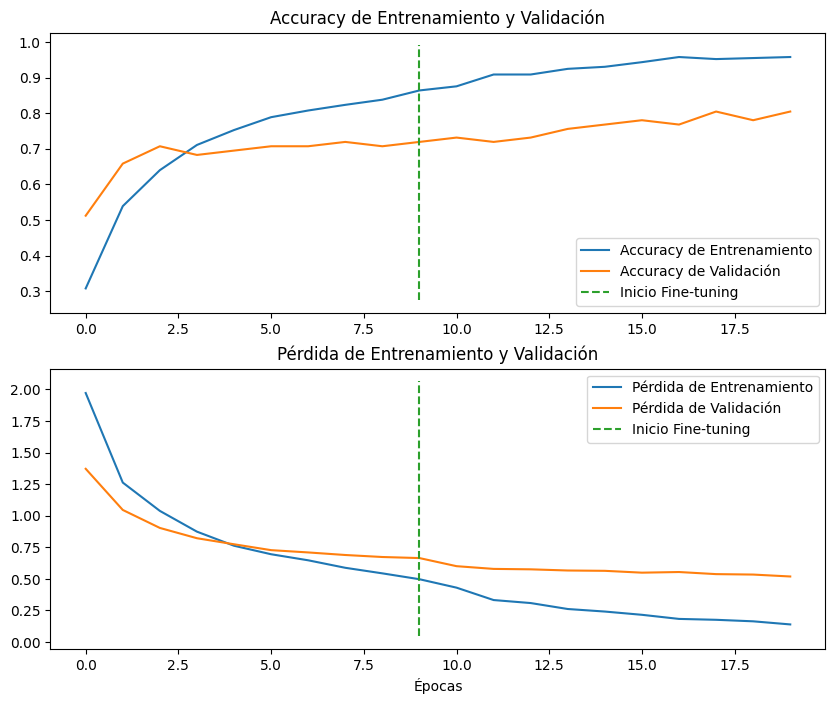

In [110]:
# --- 10. Visualizar el Historial de Entrenamiento ---
def plot_history(history_initial, history_fine_tune):
    acc = history_initial.history["accuracy"] + history_fine_tune.history["accuracy"]
    val_acc = (
        history_initial.history["val_accuracy"]
        + history_fine_tune.history["val_accuracy"]
    )
    loss = history_initial.history["loss"] + history_fine_tune.history["loss"]
    val_loss = (
        history_initial.history["val_loss"] + history_fine_tune.history["val_loss"]
    )

    plt.figure(figsize=(10, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label="Accuracy de Entrenamiento")
    plt.plot(val_acc, label="Accuracy de Validación")
    plt.plot(
        [epochs_initial - 1, epochs_initial - 1],
        plt.ylim(),
        label="Inicio Fine-tuning",
        linestyle="--",
    )
    plt.legend(loc="lower right")
    plt.title("Accuracy de Entrenamiento y Validación")

    plt.subplot(2, 1, 2)
    plt.plot(loss, label="Pérdida de Entrenamiento")
    plt.plot(val_loss, label="Pérdida de Validación")
    plt.plot(
        [epochs_initial - 1, epochs_initial - 1],
        plt.ylim(),
        label="Inicio Fine-tuning",
        linestyle="--",
    )
    plt.legend(loc="upper right")
    plt.title("Pérdida de Entrenamiento y Validación")
    plt.xlabel("Épocas")
    plt.show()


plot_history(history_initial, history_fine_tune)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step


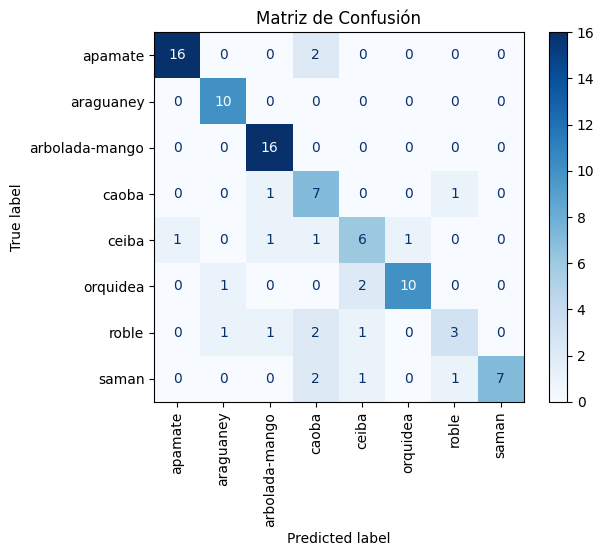

In [111]:
# Ver matriz de confusión
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def plot_confusion_matrix(model, test_ds):
    y_true = []
    y_pred = []

    for images, labels in test_ds:
        predictions = model.predict(images)
        y_true.extend(labels.numpy())
        y_pred.extend(predictions.argmax(axis=1))

    cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Matriz de Confusión")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.xticks(rotation=90)
    plt.show()

plot_confusion_matrix(model, test_ds)